In [ ]:
!pip install wget torchinfo
!wget -O NCT-CRC-HE-100K.zip https://zenodo.org/record/1214456/files/NCT-CRC-HE-100K.zip
!unzip -qq NCT-CRC-HE-100K.zip -d train

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=00b5027bf3d6dad73516200f333b0ad287387486073da504a4e03f8c0fb9959b
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget
--2025-01-25 08:11:59--  https://zenodo.org/record/1214456/files/NCT-CRC-HE-100K.zip
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.43.25, 188.185.45.92, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/1214456/files/NCT-CRC-HE-100K.zip [following]
--2025-01-25 08:12:00--  https://zenodo.org/records/1214456/files/NCT-CRC-HE-100K.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 11690284003 (11G) [application/octet-stream]
Saving to: ‘NCT-CRC-HE-100K.zip’

NCT-CRC-HE-100K.zip 100%[===================>] 

In [ ]:
!pip install torchinfo

import cv2
import timm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset
import numpy as np
from tqdm import tqdm

import itertools
from torch import profiler
from torchinfo import summary

from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix
from PIL import Image

from matplotlib import pyplot as plt

import random
import torchvision.transforms.functional as TF

from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

In [ ]:
model = timm.create_model('vit_base_patch8_224', pretrained=False, num_classes=9)

print(model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(8, 8), stride=(8, 8))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()
  

In [ ]:
batch_size = 32
learning_rate = 5e-4
decay_rate = 1e-6
num_epochs = 30

In [ ]:
print(summary(model, input_size=(32, 3, 224, 224)))

Layer (type:depth-idx)                   Output Shape              Param #
VisionTransformer                        [32, 9]                   603,648
├─PatchEmbed: 1-1                        [32, 784, 768]            --
│    └─Conv2d: 2-1                       [32, 768, 28, 28]         148,224
│    └─Identity: 2-2                     [32, 784, 768]            --
├─Dropout: 1-2                           [32, 785, 768]            --
├─Identity: 1-3                          [32, 785, 768]            --
├─Identity: 1-4                          [32, 785, 768]            --
├─Sequential: 1-5                        [32, 785, 768]            --
│    └─Block: 2-3                        [32, 785, 768]            --
│    │    └─LayerNorm: 3-1               [32, 785, 768]            1,536
│    │    └─Attention: 3-2               [32, 785, 768]            2,362,368
│    │    └─Identity: 3-3                [32, 785, 768]            --
│    │    └─Identity: 3-4                [32, 785, 768]          

In [ ]:
print(summary(model, input_size=(32, 3, 224, 224), verbose=2))

Layer (type:depth-idx)                   Output Shape              Param #
VisionTransformer                        [32, 9]                   603,648
├─cls_token                                                        ├─768
├─pos_embed                                                        └─602,880
├─PatchEmbed: 1-1                        [32, 784, 768]            --
│    └─proj.weight                                                 ├─147,456
│    └─proj.bias                                                   └─768
│    └─Conv2d: 2-1                       [32, 768, 28, 28]         148,224
│    │    └─weight                                                 ├─147,456
│    │    └─bias                                                   └─768
│    └─Identity: 2-2                     [32, 784, 768]            --
├─Dropout: 1-2                           [32, 785, 768]            --
├─Identity: 1-3                          [32, 785, 768]            --
├─Identity: 1-4                          [32,

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [ ]:
train_dir = './train/NCT-CRC-HE-100K'
dataset = datasets.ImageFolder(root=train_dir, transform=transform)

In [ ]:
data_paths, labels = zip(*dataset.samples)
labels = np.array(labels)

# 7 : 3 split
train_idx, tmp_idx, _, tmp_labels = train_test_split(
    np.arange(len(labels)), labels, test_size=0.3, stratify=labels, random_state=42
)

# 3 -> 1.5 : 1.5 split
val_idx, test_idx = train_test_split(
    tmp_idx, test_size=0.5, stratify=tmp_labels, random_state=42
)

train_data = Subset(dataset, train_idx)
val_data = Subset(dataset, val_idx)
test_data = Subset(dataset, test_idx)

In [ ]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

print(f"Train set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")

Train set size: 70000
Validation set size: 15000
Test set size: 15000


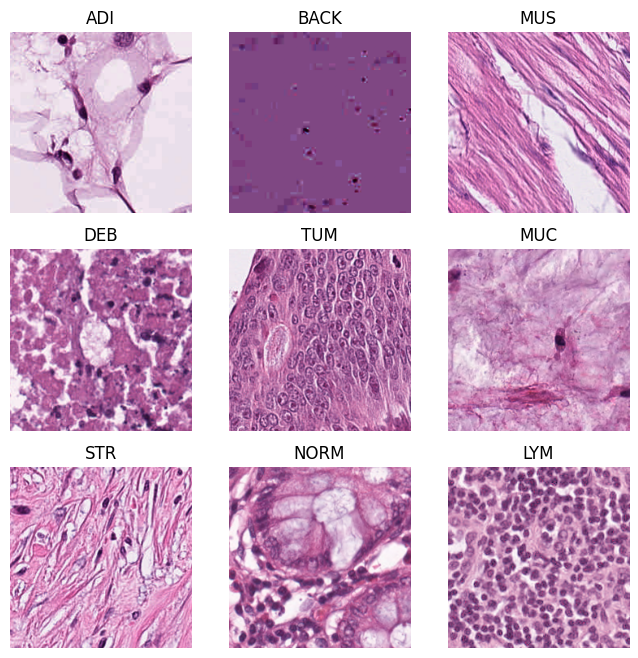

In [ ]:
# Show one example per class from the training dataset
import matplotlib.pyplot as plt

# Prepare a dictionary to store one example per class
class_examples = {}
for images, labels in train_loader:
    for img, label in zip(images, labels):
        label = label.item()
        if label not in class_examples:
            class_examples[label] = img
        # Stop if we already have one example for each class
        if len(class_examples) == len(dataset.classes):
            break
    if len(class_examples) == len(dataset.classes):
        break

# Display the images and their labels
figure = plt.figure(figsize=(8, 8))
cols = 3  # You can adjust the number of columns as needed
rows = (len(dataset.classes) + cols - 1) // cols  # Calculate required rows
for i, (label, img) in enumerate(class_examples.items(), start=1):
    figure.add_subplot(rows, cols, i)
    plt.title(dataset.classes[label])
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0).numpy())  # Convert tensor to numpy for display
plt.show()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay = decay_rate)

In [ ]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [ ]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total
    print(f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {accuracy:.2f}%")
    train_losses.append(epoch_loss)
    train_accuracies.append(accuracy)


In [ ]:
def evaluate(model, data_loader, criterion, device, phase="Validation"):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc=f"{phase}"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Save all labels and predictions for balanced accuracy
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    epoch_loss = running_loss / len(data_loader)
    accuracy = 100 * correct / total
    balanced_acc = balanced_accuracy_score(all_labels, all_predictions)

    print(f"{phase} Loss: {epoch_loss:.4f}, {phase} Accuracy: {accuracy:.2f}%")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")

    val_losses.append(epoch_loss)
    val_accuracies.append(accuracy)

In [ ]:
def measure_inference_time(model, data_loader, device):
    model.eval()
    times = []

    with torch.no_grad():
        for inputs, _ in data_loader:
            inputs = inputs.to(device)
            start_time = torch.cuda.Event(enable_timing=True)
            end_time = torch.cuda.Event(enable_timing=True)

            start_time.record()
            _ = model(inputs)  # inference 수행
            end_time.record()

            # 시간 측정
            torch.cuda.synchronize()  # CUDA에서 모든 커널이 완료될 때까지 대기
            elapsed_time = start_time.elapsed_time(end_time)  # 밀리초 단위로 반환
            times.append(elapsed_time)

    # 통계량 계산
    times_np = np.array(times)
    total_inferences = len(times_np)
    avg_time = np.mean(times_np)
    std_dev = np.std(times_np)
    max_time = np.max(times_np)
    min_time = np.min(times_np)

    # 결과 출력
    print(f"Inference Time Measurement Results:")
    print(f"Total Inferences: {total_inferences}")
    print(f"Average Time: {avg_time:.2f} ms")
    print(f"Standard Deviation: {std_dev:.2f} ms")
    print(f"Maximum Time: {max_time:.2f} ms")
    print(f"Minimum Time: {min_time:.2f} ms")

    return times

In [ ]:
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train(model, train_loader, criterion, optimizer, device)
    evaluate(model, val_loader, criterion, device, phase="Validation")


Epoch 1/30


Training: 100%|██████████| 2188/2188 [33:44<00:00,  1.08it/s]


Train Loss: 1.6163, Train Accuracy: 38.23%


Validation: 100%|██████████| 469/469 [02:31<00:00,  3.10it/s]


Validation Loss: 1.0643, Validation Accuracy: 60.67%
Balanced Accuracy: 0.6092

Epoch 2/30


Training: 100%|██████████| 2188/2188 [33:43<00:00,  1.08it/s]


Train Loss: 0.9577, Train Accuracy: 64.45%


Validation: 100%|██████████| 469/469 [02:31<00:00,  3.10it/s]


Validation Loss: 0.8486, Validation Accuracy: 68.06%
Balanced Accuracy: 0.6675

Epoch 3/30


Training: 100%|██████████| 2188/2188 [33:42<00:00,  1.08it/s]


Train Loss: 0.7092, Train Accuracy: 73.62%


Validation: 100%|██████████| 469/469 [02:30<00:00,  3.11it/s]


Validation Loss: 0.6516, Validation Accuracy: 75.74%
Balanced Accuracy: 0.7573

Epoch 4/30


Training: 100%|██████████| 2188/2188 [33:42<00:00,  1.08it/s]


Train Loss: 0.5696, Train Accuracy: 79.06%


Validation: 100%|██████████| 469/469 [02:30<00:00,  3.11it/s]


Validation Loss: 0.6286, Validation Accuracy: 76.29%
Balanced Accuracy: 0.7690

Epoch 5/30


Training: 100%|██████████| 2188/2188 [33:42<00:00,  1.08it/s]


Train Loss: 0.4978, Train Accuracy: 81.94%


Validation: 100%|██████████| 469/469 [02:31<00:00,  3.10it/s]


Validation Loss: 0.4675, Validation Accuracy: 83.53%
Balanced Accuracy: 0.8313

Epoch 6/30


Training: 100%|██████████| 2188/2188 [33:42<00:00,  1.08it/s]


Train Loss: 0.4599, Train Accuracy: 83.17%


Validation: 100%|██████████| 469/469 [02:31<00:00,  3.11it/s]


Validation Loss: 0.4542, Validation Accuracy: 83.89%
Balanced Accuracy: 0.8315

Epoch 7/30


Training: 100%|██████████| 2188/2188 [33:41<00:00,  1.08it/s]


Train Loss: 0.4183, Train Accuracy: 84.84%


Validation: 100%|██████████| 469/469 [02:30<00:00,  3.11it/s]


Validation Loss: 0.5420, Validation Accuracy: 80.02%
Balanced Accuracy: 0.8101

Epoch 8/30


Training: 100%|██████████| 2188/2188 [33:42<00:00,  1.08it/s]


Train Loss: 0.3881, Train Accuracy: 85.95%


Validation: 100%|██████████| 469/469 [02:31<00:00,  3.11it/s]


Validation Loss: 0.3620, Validation Accuracy: 87.02%
Balanced Accuracy: 0.8718

Epoch 9/30


Training: 100%|██████████| 2188/2188 [33:42<00:00,  1.08it/s]


Train Loss: 0.3680, Train Accuracy: 86.74%


Validation: 100%|██████████| 469/469 [02:31<00:00,  3.10it/s]


Validation Loss: 0.4294, Validation Accuracy: 84.56%
Balanced Accuracy: 0.8344

Epoch 10/30


Training: 100%|██████████| 2188/2188 [33:42<00:00,  1.08it/s]


Train Loss: 0.3463, Train Accuracy: 87.53%


Validation: 100%|██████████| 469/469 [02:31<00:00,  3.11it/s]


Validation Loss: 0.3330, Validation Accuracy: 88.02%
Balanced Accuracy: 0.8787

Epoch 11/30


Training: 100%|██████████| 2188/2188 [33:43<00:00,  1.08it/s]


Train Loss: 0.3373, Train Accuracy: 87.83%


Validation: 100%|██████████| 469/469 [02:31<00:00,  3.10it/s]


Validation Loss: 0.3627, Validation Accuracy: 87.20%
Balanced Accuracy: 0.8700

Epoch 12/30


Training: 100%|██████████| 2188/2188 [33:43<00:00,  1.08it/s]


Train Loss: 0.3012, Train Accuracy: 89.26%


Validation: 100%|██████████| 469/469 [02:31<00:00,  3.10it/s]


Validation Loss: 0.2837, Validation Accuracy: 89.89%
Balanced Accuracy: 0.8940

Epoch 13/30


Training: 100%|██████████| 2188/2188 [33:44<00:00,  1.08it/s]


Train Loss: 0.3058, Train Accuracy: 88.91%


Validation: 100%|██████████| 469/469 [02:31<00:00,  3.11it/s]


Validation Loss: 0.2990, Validation Accuracy: 89.44%
Balanced Accuracy: 0.8912

Epoch 14/30


Validation: 100%|██████████| 469/469 [02:31<00:00,  3.10it/s]


Validation Loss: 0.3210, Validation Accuracy: 88.57%
Balanced Accuracy: 0.8796

Epoch 15/30


Training: 100%|██████████| 2188/2188 [33:43<00:00,  1.08it/s]


Train Loss: 0.2780, Train Accuracy: 90.05%


Validation: 100%|██████████| 469/469 [02:31<00:00,  3.10it/s]


Validation Loss: 0.2806, Validation Accuracy: 89.92%
Balanced Accuracy: 0.8965

Epoch 16/30


Training: 100%|██████████| 2188/2188 [33:44<00:00,  1.08it/s]


Train Loss: 0.2484, Train Accuracy: 91.14%


Validation: 100%|██████████| 469/469 [02:31<00:00,  3.10it/s]


Validation Loss: 0.2646, Validation Accuracy: 90.46%
Balanced Accuracy: 0.9040

Epoch 17/30


Training: 100%|██████████| 2188/2188 [33:44<00:00,  1.08it/s]


Train Loss: 0.2345, Train Accuracy: 91.51%


Validation: 100%|██████████| 469/469 [02:31<00:00,  3.09it/s]


Validation Loss: 0.2353, Validation Accuracy: 91.63%
Balanced Accuracy: 0.9111

Epoch 18/30


Training: 100%|██████████| 2188/2188 [33:43<00:00,  1.08it/s]


Train Loss: 0.2291, Train Accuracy: 91.81%


Validation: 100%|██████████| 469/469 [02:31<00:00,  3.09it/s]


Validation Loss: 0.2283, Validation Accuracy: 92.15%
Balanced Accuracy: 0.9209

Epoch 19/30


Training: 100%|██████████| 2188/2188 [33:44<00:00,  1.08it/s]


Train Loss: 0.2242, Train Accuracy: 92.01%


Validation: 100%|██████████| 469/469 [02:31<00:00,  3.10it/s]


Validation Loss: 0.2603, Validation Accuracy: 91.39%
Balanced Accuracy: 0.9106

Epoch 20/30


Training: 100%|██████████| 2188/2188 [33:44<00:00,  1.08it/s]


Train Loss: 0.2225, Train Accuracy: 92.03%


Validation: 100%|██████████| 469/469 [02:31<00:00,  3.10it/s]


Validation Loss: 0.2289, Validation Accuracy: 91.85%
Balanced Accuracy: 0.9168

Epoch 21/30


Training: 100%|██████████| 2188/2188 [33:45<00:00,  1.08it/s]


Train Loss: 0.1933, Train Accuracy: 93.21%


Validation: 100%|██████████| 469/469 [02:31<00:00,  3.10it/s]


Validation Loss: 0.2349, Validation Accuracy: 91.70%
Balanced Accuracy: 0.9157

Epoch 22/30


Training: 100%|██████████| 2188/2188 [33:45<00:00,  1.08it/s]


Train Loss: 0.1938, Train Accuracy: 92.96%


Validation: 100%|██████████| 469/469 [02:31<00:00,  3.09it/s]


Validation Loss: 0.2369, Validation Accuracy: 91.85%
Balanced Accuracy: 0.9174

Epoch 23/30


Training: 100%|██████████| 2188/2188 [33:45<00:00,  1.08it/s]


Train Loss: 0.1917, Train Accuracy: 93.10%


Validation: 100%|██████████| 469/469 [02:31<00:00,  3.10it/s]


Validation Loss: 0.2619, Validation Accuracy: 90.60%
Balanced Accuracy: 0.9009

Epoch 24/30


Training: 100%|██████████| 2188/2188 [33:44<00:00,  1.08it/s]


Train Loss: 0.1806, Train Accuracy: 93.47%


Validation: 100%|██████████| 469/469 [02:31<00:00,  3.09it/s]


Validation Loss: 0.2637, Validation Accuracy: 90.98%
Balanced Accuracy: 0.9065

Epoch 25/30


Training: 100%|██████████| 2188/2188 [33:44<00:00,  1.08it/s]


Train Loss: 0.1700, Train Accuracy: 93.91%


Validation: 100%|██████████| 469/469 [02:31<00:00,  3.10it/s]


Validation Loss: 0.2067, Validation Accuracy: 92.81%
Balanced Accuracy: 0.9258

Epoch 26/30


Training: 100%|██████████| 2188/2188 [33:44<00:00,  1.08it/s]


Train Loss: 0.1582, Train Accuracy: 94.31%


Validation: 100%|██████████| 469/469 [02:31<00:00,  3.09it/s]


Validation Loss: 0.2142, Validation Accuracy: 92.51%
Balanced Accuracy: 0.9213

Epoch 27/30


Training: 100%|██████████| 2188/2188 [33:45<00:00,  1.08it/s]


Train Loss: 0.1541, Train Accuracy: 94.42%


Validation: 100%|██████████| 469/469 [02:31<00:00,  3.09it/s]


Validation Loss: 0.2068, Validation Accuracy: 92.76%
Balanced Accuracy: 0.9269

Epoch 28/30


Training: 100%|██████████| 2188/2188 [33:44<00:00,  1.08it/s]


Train Loss: 0.1560, Train Accuracy: 94.41%


Validation: 100%|██████████| 469/469 [02:31<00:00,  3.09it/s]


Validation Loss: 0.1953, Validation Accuracy: 93.16%
Balanced Accuracy: 0.9334

Epoch 29/30


Training: 100%|██████████| 2188/2188 [33:44<00:00,  1.08it/s]


Train Loss: 0.1394, Train Accuracy: 94.97%


Validation: 100%|██████████| 469/469 [02:32<00:00,  3.08it/s]


Validation Loss: 0.1651, Validation Accuracy: 94.36%
Balanced Accuracy: 0.9431

Epoch 30/30


Training: 100%|██████████| 2188/2188 [33:44<00:00,  1.08it/s]


Train Loss: 0.1323, Train Accuracy: 95.20%


Validation: 100%|██████████| 469/469 [02:31<00:00,  3.09it/s]

Validation Loss: 0.1874, Validation Accuracy: 93.57%
Balanced Accuracy: 0.9343


In [ ]:
print("\nFinal Test Evaluation")
evaluate(model, test_loader, criterion, device, phase="Test")


Final Test Evaluation


Test: 100%|██████████| 469/469 [02:31<00:00,  3.09it/s]

Test Loss: 0.1887, Test Accuracy: 93.46%
Balanced Accuracy: 0.9336


In [ ]:
print("train_loss length : ", len(train_losses))
print("train_acc length : ", len(train_accuracies))
print("val_loss length : ", len(val_losses))
print("val_acc length : ", len(val_accuracies))

print("val_adj : ", len(val_losses[:num_epochs]))
print("val_acc_adj : ", len(val_accuracies[:num_epochs]))

train_loss length :  30
train_acc length :  30
val_loss length :  31
val_acc length :  31
val_adj :  30
val_acc_adj :  30


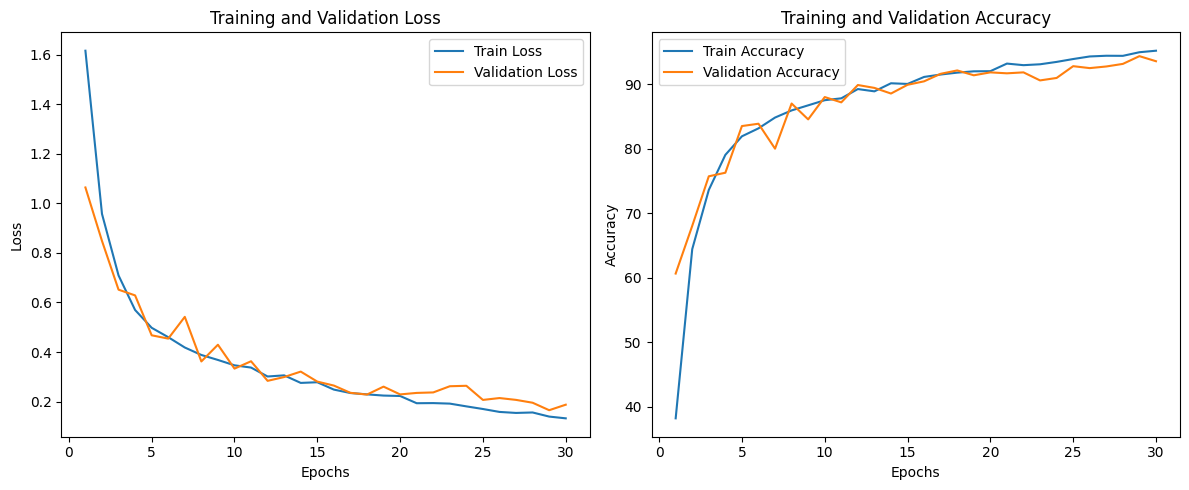

In [ ]:
# Plot the metrics
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses[:num_epochs], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Train Accuracy")
plt.plot(epochs, val_accuracies[:num_epochs], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
times = measure_inference_time(model, test_loader, device)

Inference Time Measurement Results:
Total Inferences: 469
Average Time: 281.68 ms
Standard Deviation: 3.06 ms
Maximum Time: 282.06 ms
Minimum Time: 215.63 ms


In [ ]:
dummy_input = torch.randn(32, 3, 224, 224).cuda()

# Profiling inference
with profiler.profile(
    activities=[
       profiler.ProfilerActivity.CPU,
        profiler.ProfilerActivity.CUDA,  # Include if using GPU
    ],
    on_trace_ready=profiler.tensorboard_trace_handler("./logs"),  # Optional logging
    record_shapes=True,
    with_stack=True
) as prof:
    with torch.no_grad():
        model(dummy_input)


# Print results
print(prof.key_averages().table(sort_by="cuda_time_total" if torch.cuda.is_available() else "cpu_time_total", row_limit=10))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                           aten::linear         0.20%     558.420us         2.13%       5.918ms     120.775us       0.000us         0.00%     226.533ms       4.623ms            49  
                                            aten::addmm         0.66%       1.837ms         1.67%       4.629ms      94.470us     226.533ms        80.48%     226.533ms       4.623ms            49  
         

In [ ]:
from sklearn.metrics import f1_score, recall_score, precision_score, roc_curve, auc

def score_evaluate(model, data_loader, criterion, device, phase="Validation"):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc=f"{phase}"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    overall_f1 = f1_score(all_labels, all_preds, average="macro")
    overall_recall = recall_score(all_labels, all_preds, average="macro")
    overall_precision = precision_score(all_labels, all_preds, average="macro")

    f1_per_class = f1_score(all_labels, all_preds, average=None)
    recall_per_class = recall_score(all_labels, all_preds, average=None)
    precision_per_class = precision_score(all_labels, all_preds, average=None)
    class_labels = sorted(set(all_labels))

    epoch_loss = running_loss / len(data_loader)
    accuracy = 100 * correct / total
    print(f"{phase} Loss: {epoch_loss:.4f}, {phase} Accuracy: {accuracy:.2f}%")
    val_losses.append(epoch_loss)
    val_accuracies.append(accuracy)

    print(f"Overall - F1: {overall_f1:.4f}, Recall: {overall_recall:.4f}, Precision: {overall_precision:.4f}")
    print("Per-Class Metrics:")
    for i, label in enumerate(class_labels):
        print(f"Class {label} - F1: {f1_per_class[i]:.4f}, Recall: {recall_per_class[i]:.4f}, Precision: {precision_per_class[i]:.4f}")

    return overall_f1, overall_recall, overall_precision, f1_per_class, recall_per_class, precision_per_class

In [ ]:
overall_f1, overall_recall, overall_precision, f1_per_class, recall_per_class, precision_per_class = score_evaluate(model, test_loader, criterion, device, phase="Test")

Test: 100%|██████████| 469/469 [02:32<00:00,  3.08it/s]

Test Loss: 0.1887, Test Accuracy: 93.46%
Overall - F1: 0.9327, Recall: 0.9336, Precision: 0.9333
Per-Class Metrics:
Class 0 - F1: 0.9847, Recall: 0.9898, Precision: 0.9797
Class 1 - F1: 0.9921, Recall: 0.9880, Precision: 0.9962
Class 2 - F1: 0.9041, Recall: 0.9044, Precision: 0.9039
Class 3 - F1: 0.9899, Recall: 0.9896, Precision: 0.9902
Class 4 - F1: 0.9144, Recall: 0.9678, Precision: 0.8665
Class 5 - F1: 0.9387, Recall: 0.9508, Precision: 0.9270
Class 6 - F1: 0.8875, Recall: 0.8791, Precision: 0.8961
Class 7 - F1: 0.8551, Recall: 0.8060, Precision: 0.9106
Class 8 - F1: 0.9282, Recall: 0.9269, Precision: 0.9295


In [ ]:
from sklearn.preprocessing import label_binarize

def roc_auc(model, data_loader, device, num_classes):

    y = ["F1", "Precision", "Recall"]

    model.eval()
    all_labels = []
    all_scores = []

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc="ROC AUC"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_scores.extend(outputs.cpu().numpy())

    all_labels = label_binarize(all_labels, classes=list(range(num_classes)))
    print(f"Binarized all_labels shape: {all_labels.shape}")
    print(f"All_scores shape: {np.array(all_scores).shape}")

    fpr, tpr, _ = roc_curve(all_labels.ravel(), np.array(all_scores).ravel())
    roc_auc_value = auc(fpr, tpr)

    plt.figure(figsize=(9, 7))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_value:0.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    print(f"Overall ROC AUC: {roc_auc_value:.4f}")

    return fpr, tpr, roc_auc_value

ROC AUC: 100%|██████████| 469/469 [02:31<00:00,  3.10it/s]

Binarized all_labels shape: (15000, 9)
All_scores shape: (15000, 9)


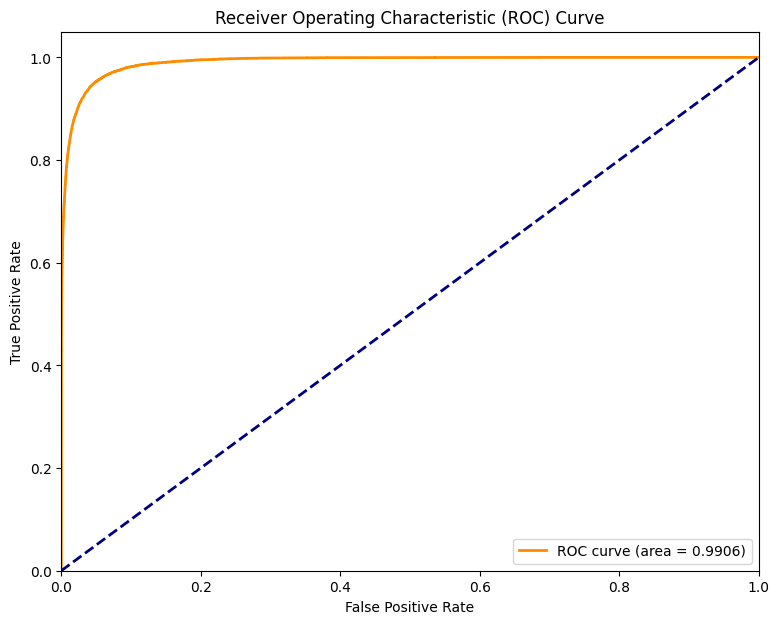

Overall ROC AUC: 0.9906


In [ ]:
fpr, tpr, roc_auc_value = roc_auc(model, test_loader, device, num_classes=9)

<Figure size 2000x1200 with 0 Axes>

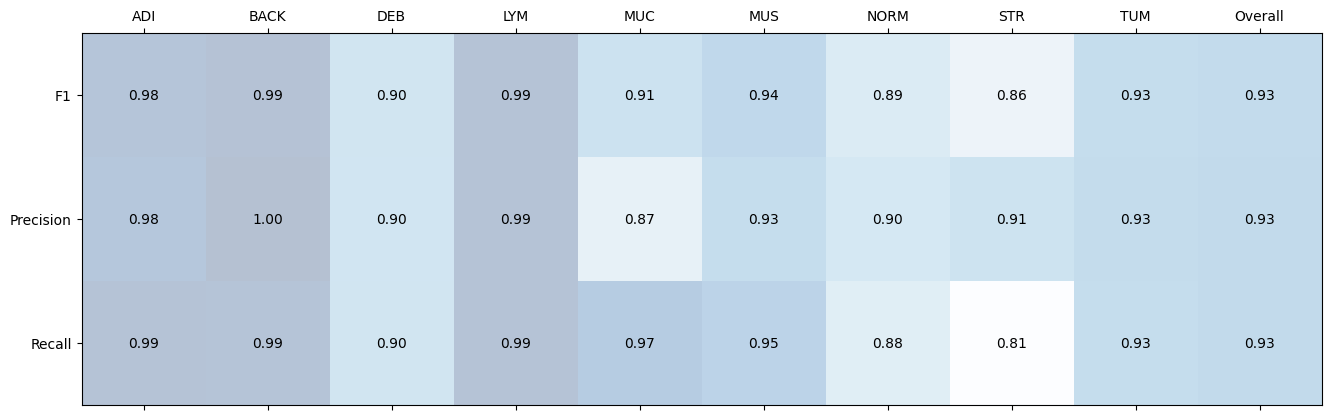

In [ ]:
x = ["ADI", "BACK", "DEB", "LYM", "MUC", "MUS", "NORM", 'STR', "TUM"]
y = ["F1", "Precision", "Recall"]

f1_score_list = []
precision_score_list = []
recall_score_list = []

for i, class_name in enumerate(x):
    f1_score_list.append(f1_per_class[i])
    precision_score_list.append(precision_per_class[i])
    recall_score_list.append(recall_per_class[i])

x.append("Overall")
f1_score_list.append(overall_f1)
precision_score_list.append(overall_precision)
recall_score_list.append(overall_recall)

score_list = [f1_score_list, precision_score_list, recall_score_list]
score_list = np.array(score_list)
plt.figure(figsize=(20, 12))
score_cm = plt.matshow(score_list, cmap=plt.cm.Blues, alpha=0.3)
plt.xticks(range(len(x)), x)
plt.yticks(range(len(y)), y)
for i in range(len(y)):
    for j in range(len(x)):
        # 행렬의 각각의 수치를 각 칸의 중앙에 넣어준다
        plt.text(x=j, y=i,
                     s="{:.2f}".format(score_list[i, j]),
                     va='center',
                     ha='center',
                     )

In [ ]:
save_path = "./ViT_patch8_NCT_CRC_HE.pth"
torch.save(model.state_dict(), save_path)
print(f"Model weights saved to {save_path}")

Model weights saved to ./ViT_patch8_NCT_CRC_HE.pth
